# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = gym.make('BipedalWalker-v2')

random_seed = 10
env.seed(random_seed)

# from agent import Agent
# agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], 
#               random_seed=random_seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[10]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
env.action_space, env.observation_space

(Box(4,), Box(24,))

In [4]:
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

In [5]:
action_size, state_size

(4, 24)

In [6]:
env.observation_space.low, env.observation_space.high

(array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32))

In [7]:
env.action_space.low, env.action_space.high

(array([-1., -1., -1., -1.], dtype=float32),
 array([1., 1., 1., 1.], dtype=float32))

### 3. Instantiate DDPG Agent

In [9]:
from agent2 import Agent

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [16]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=1000
# n_steps=1000
# n_learn=10
# learn_every=20
R_goal=0 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot
Rs = [] # plot
dlosses = []
glosses = []

In [17]:
for i_episode in range(n_episodes):
    
    # # Reset Env
    # env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
    # S = env_info.vector_observations                   # get the current state (for each agent)
    s = env.reset() # s: state [-1:1, -1:1, -8:8]
    s_ = np.zeros_like(s) # s_: predicted state [-1:1, -1:1, -8:8]
    #print(s.shape)

    #Rs = np.zeros(num_agents)                            # initialize the score (for each agent)
    R = 0 # R: total reward
    gloss_batch = []
    dloss_batch = []

    #for i_step in range(n_steps):
    while True:
        s = np.reshape(s, [1, -1])
        s_ = np.reshape(s_, [1, -1])
        a = agent.act(s, s_) # a=[-2, 2]
        #a *= 2
        #print(a.shape)
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        # env_info = env.step(A)[brain_name]            # send all actions to the environment
        # S2 = env_info.vector_observations          # get next state (for each agent)
        # rewards = env_info.rewards                          # get reward (for each agent)
        # dones = env_info.local_done                         # see if episode finished
        #s2: next_state, r: reward, done/terminal, env: environment
        a = np.reshape(a, [-1])
        s2, r, done, _ = env.step(a)
        #print(s2.shape, r, done)

        #s2_, q_ = agent.env(s, a)
        a = np.reshape(a, [1, -1])
        s2_, _ = agent.env(s, a)
        # print(s2_)
        # s2_ = np.tanh(s2_) # predicted next state [-1:1, -1:1, -8:8]
        # print(s2_)
        # s2_[2] = s2_[2] * 8
        # print(s2_)

        # for s, a, reward, s2, done in zip(S, A, rewards, S2, dones):
        # agent.step(state, action, reward, next_state, done) # send actions to the agent
        agent.step(s, a, r, s2, done, s_, s2_)

        R += r                           # update the score (for each agent)
        s = s2                                # roll over the states to the next state
        s_ = s2_                                # roll over predicted states to the predicted next state

        # if i_step%learn_every == 0:
        losses = []
        for _ in range(20):
            dloss = agent.start_dlearn()
            #print(dloss)
            losses.append(dloss)
        dloss_batch.append(np.mean(losses))
            
        #print(len(agent.memory))
        gloss = agent.start_glearn()
        gloss_batch.append(gloss)

        # if np.any(dones):                                   # exit loop if episode finished
        #     break
        if done:
            break

    #meanR = np.mean(Rs)
    #Rs_deque.append(meanR)
    Rs_deque.append(R)
    meanRs.append(np.mean(Rs_deque)) # plot
    Rs.append(R) # plot
    dlosses.append(np.mean(dloss_batch))
    glosses.append(np.mean(gloss_batch))

    print('\rEpisode {}\tTotal Average Score: {:.2f}\tGloss: {:.2f}, \tDloss: {:.2f}'.format(
           i_episode+1, np.mean(Rs_deque), np.mean(gloss_batch), np.mean(dloss_batch)))  
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-bipedal.pth')
        torch.save(agent.d.state_dict(), 'd-bipedal.pth')
        break

Episode 1	Total Average Score: -91.86	Gloss: 0.00, 	Dloss: 0.00
Episode 2	Total Average Score: -91.89	Gloss: 0.00, 	Dloss: 0.00
Episode 3	Total Average Score: -91.92	Gloss: 0.00, 	Dloss: 0.00
Episode 4	Total Average Score: -91.91	Gloss: 0.00, 	Dloss: 0.00
Episode 5	Total Average Score: -91.98	Gloss: 0.00, 	Dloss: 0.00
Episode 6	Total Average Score: -91.98	Gloss: 0.00, 	Dloss: 0.00
Episode 7	Total Average Score: -91.97	Gloss: 0.00, 	Dloss: 0.00
Episode 8	Total Average Score: -92.11	Gloss: -0.12, 	Dloss: 38.91
Episode 9	Total Average Score: -94.42	Gloss: -0.01, 	Dloss: 64.31
Episode 10	Total Average Score: -96.61	Gloss: 0.19, 	Dloss: 60.49
Episode 11	Total Average Score: -98.79	Gloss: 0.27, 	Dloss: 60.82
Episode 12	Total Average Score: -102.12	Gloss: 0.78, 	Dloss: 36.48
Episode 13	Total Average Score: -103.46	Gloss: 1.26, 	Dloss: 16.98
Episode 14	Total Average Score: -104.66	Gloss: 1.81, 	Dloss: 8.02
Episode 15	Total Average Score: -104.59	Gloss: 2.54, 	Dloss: 3.08
Episode 16	Total Avera

Episode 125	Total Average Score: -116.20	Gloss: 2.93, 	Dloss: 1.50
Episode 126	Total Average Score: -116.26	Gloss: 2.59, 	Dloss: 1.58
Episode 127	Total Average Score: -116.03	Gloss: 1.88, 	Dloss: 1.86
Episode 128	Total Average Score: -115.79	Gloss: 0.98, 	Dloss: 2.39
Episode 129	Total Average Score: -115.75	Gloss: 0.06, 	Dloss: 3.06
Episode 130	Total Average Score: -115.80	Gloss: -1.31, 	Dloss: 4.08
Episode 131	Total Average Score: -115.86	Gloss: -2.87, 	Dloss: 4.84
Episode 132	Total Average Score: -115.91	Gloss: -3.87, 	Dloss: 5.45
Episode 133	Total Average Score: -115.86	Gloss: -4.55, 	Dloss: 5.63
Episode 134	Total Average Score: -115.91	Gloss: -5.34, 	Dloss: 5.91
Episode 135	Total Average Score: -115.66	Gloss: -5.97, 	Dloss: 6.16
Episode 136	Total Average Score: -115.51	Gloss: -6.82, 	Dloss: 6.66
Episode 137	Total Average Score: -115.09	Gloss: -12.28, 	Dloss: 4.67
Episode 138	Total Average Score: -114.70	Gloss: -10.06, 	Dloss: 1.16
Episode 139	Total Average Score: -114.74	Gloss: -9.

Episode 246	Total Average Score: -102.66	Gloss: 1.30, 	Dloss: 0.64
Episode 247	Total Average Score: -102.47	Gloss: 1.36, 	Dloss: 0.63
Episode 248	Total Average Score: -102.38	Gloss: 1.31, 	Dloss: 0.63
Episode 249	Total Average Score: -102.15	Gloss: 1.36, 	Dloss: 0.63
Episode 250	Total Average Score: -101.05	Gloss: 1.28, 	Dloss: 0.64
Episode 251	Total Average Score: -100.99	Gloss: 1.36, 	Dloss: 0.63
Episode 252	Total Average Score: -100.84	Gloss: 1.52, 	Dloss: 0.62
Episode 253	Total Average Score: -100.37	Gloss: 1.76, 	Dloss: 0.63
Episode 254	Total Average Score: -100.29	Gloss: 1.87, 	Dloss: 0.62
Episode 255	Total Average Score: -100.22	Gloss: 1.96, 	Dloss: 0.62
Episode 256	Total Average Score: -100.03	Gloss: 1.99, 	Dloss: 0.64
Episode 257	Total Average Score: -99.91	Gloss: 2.01, 	Dloss: 0.63
Episode 258	Total Average Score: -99.75	Gloss: 2.11, 	Dloss: 0.64
Episode 259	Total Average Score: -99.65	Gloss: 2.19, 	Dloss: 0.64
Episode 260	Total Average Score: -99.56	Gloss: 2.34, 	Dloss: 0.64

Episode 370	Total Average Score: -94.62	Gloss: 10.16, 	Dloss: 0.64
Episode 371	Total Average Score: -94.57	Gloss: 10.01, 	Dloss: 0.65
Episode 372	Total Average Score: -94.44	Gloss: 10.07, 	Dloss: 0.65
Episode 373	Total Average Score: -94.33	Gloss: 10.05, 	Dloss: 0.65
Episode 374	Total Average Score: -94.29	Gloss: 10.11, 	Dloss: 0.64
Episode 375	Total Average Score: -94.21	Gloss: 10.10, 	Dloss: 0.65
Episode 376	Total Average Score: -94.18	Gloss: 10.13, 	Dloss: 0.64
Episode 377	Total Average Score: -94.04	Gloss: 10.14, 	Dloss: 0.64
Episode 378	Total Average Score: -93.92	Gloss: 10.13, 	Dloss: 0.65
Episode 379	Total Average Score: -93.86	Gloss: 10.23, 	Dloss: 0.64
Episode 380	Total Average Score: -93.79	Gloss: 10.19, 	Dloss: 0.65
Episode 381	Total Average Score: -93.75	Gloss: 10.14, 	Dloss: 0.65
Episode 382	Total Average Score: -93.71	Gloss: 10.15, 	Dloss: 0.66
Episode 383	Total Average Score: -93.86	Gloss: 10.16, 	Dloss: 0.66
Episode 384	Total Average Score: -93.83	Gloss: 10.23, 	Dloss: 

Episode 493	Total Average Score: -90.72	Gloss: 10.82, 	Dloss: 0.70
Episode 494	Total Average Score: -90.69	Gloss: 10.59, 	Dloss: 0.69
Episode 495	Total Average Score: -90.73	Gloss: 10.53, 	Dloss: 0.69
Episode 496	Total Average Score: -90.65	Gloss: 10.74, 	Dloss: 0.69
Episode 497	Total Average Score: -90.67	Gloss: 10.76, 	Dloss: 0.70
Episode 498	Total Average Score: -90.73	Gloss: 10.90, 	Dloss: 0.71
Episode 499	Total Average Score: -90.56	Gloss: 11.15, 	Dloss: 0.69
Episode 500	Total Average Score: -90.56	Gloss: 11.14, 	Dloss: 0.69
Episode 501	Total Average Score: -90.45	Gloss: 11.00, 	Dloss: 0.68
Episode 502	Total Average Score: -90.35	Gloss: 10.92, 	Dloss: 0.68
Episode 503	Total Average Score: -90.22	Gloss: 10.66, 	Dloss: 0.67
Episode 504	Total Average Score: -90.16	Gloss: 10.69, 	Dloss: 0.67
Episode 505	Total Average Score: -90.08	Gloss: 10.71, 	Dloss: 0.67
Episode 506	Total Average Score: -90.15	Gloss: 10.39, 	Dloss: 0.68
Episode 507	Total Average Score: -90.11	Gloss: 10.55, 	Dloss: 

Episode 616	Total Average Score: -90.81	Gloss: 10.89, 	Dloss: 0.66
Episode 617	Total Average Score: -91.01	Gloss: 10.69, 	Dloss: 0.67
Episode 618	Total Average Score: -91.21	Gloss: 10.93, 	Dloss: 0.67
Episode 619	Total Average Score: -91.27	Gloss: 10.99, 	Dloss: 0.66
Episode 620	Total Average Score: -91.17	Gloss: 10.99, 	Dloss: 0.66
Episode 621	Total Average Score: -91.38	Gloss: 11.15, 	Dloss: 0.66
Episode 622	Total Average Score: -91.36	Gloss: 11.14, 	Dloss: 0.66
Episode 623	Total Average Score: -91.52	Gloss: 11.17, 	Dloss: 0.65
Episode 624	Total Average Score: -91.58	Gloss: 11.17, 	Dloss: 0.66
Episode 625	Total Average Score: -91.63	Gloss: 11.16, 	Dloss: 0.66
Episode 626	Total Average Score: -91.66	Gloss: 11.17, 	Dloss: 0.66
Episode 627	Total Average Score: -91.72	Gloss: 11.00, 	Dloss: 0.65
Episode 628	Total Average Score: -91.76	Gloss: 11.00, 	Dloss: 0.65
Episode 629	Total Average Score: -91.76	Gloss: 11.14, 	Dloss: 0.66
Episode 630	Total Average Score: -91.76	Gloss: 11.33, 	Dloss: 

Episode 739	Total Average Score: -92.09	Gloss: 11.99, 	Dloss: 0.67
Episode 740	Total Average Score: -92.16	Gloss: 12.04, 	Dloss: 0.67
Episode 741	Total Average Score: -92.32	Gloss: 12.31, 	Dloss: 0.66
Episode 742	Total Average Score: -92.43	Gloss: 12.11, 	Dloss: 0.67
Episode 743	Total Average Score: -92.50	Gloss: 12.12, 	Dloss: 0.67
Episode 744	Total Average Score: -92.47	Gloss: 12.10, 	Dloss: 0.67
Episode 745	Total Average Score: -92.55	Gloss: 12.10, 	Dloss: 0.67
Episode 746	Total Average Score: -92.52	Gloss: 11.94, 	Dloss: 0.67
Episode 747	Total Average Score: -92.56	Gloss: 12.09, 	Dloss: 0.69
Episode 748	Total Average Score: -92.62	Gloss: 12.14, 	Dloss: 0.67
Episode 749	Total Average Score: -92.54	Gloss: 12.12, 	Dloss: 0.67
Episode 750	Total Average Score: -92.55	Gloss: 12.47, 	Dloss: 0.68
Episode 751	Total Average Score: -92.55	Gloss: 12.09, 	Dloss: 0.68
Episode 752	Total Average Score: -92.60	Gloss: 11.92, 	Dloss: 0.69
Episode 753	Total Average Score: -92.57	Gloss: 12.46, 	Dloss: 

Episode 862	Total Average Score: -85.64	Gloss: 11.59, 	Dloss: 0.72
Episode 863	Total Average Score: -85.62	Gloss: 11.45, 	Dloss: 0.72
Episode 864	Total Average Score: -85.59	Gloss: 11.31, 	Dloss: 0.72
Episode 865	Total Average Score: -85.44	Gloss: 11.48, 	Dloss: 0.72
Episode 866	Total Average Score: -85.39	Gloss: 11.34, 	Dloss: 0.71
Episode 867	Total Average Score: -85.48	Gloss: 11.44, 	Dloss: 0.71
Episode 868	Total Average Score: -85.35	Gloss: 11.58, 	Dloss: 0.72
Episode 869	Total Average Score: -85.43	Gloss: 11.57, 	Dloss: 0.70
Episode 870	Total Average Score: -85.31	Gloss: 11.80, 	Dloss: 0.71
Episode 871	Total Average Score: -85.10	Gloss: 11.82, 	Dloss: 0.71
Episode 872	Total Average Score: -85.07	Gloss: 11.73, 	Dloss: 0.72
Episode 873	Total Average Score: -84.95	Gloss: 11.65, 	Dloss: 0.70
Episode 874	Total Average Score: -84.97	Gloss: 11.92, 	Dloss: 0.71
Episode 875	Total Average Score: -84.91	Gloss: 11.84, 	Dloss: 0.71
Episode 876	Total Average Score: -84.85	Gloss: 11.48, 	Dloss: 

Episode 985	Total Average Score: -88.01	Gloss: 10.70, 	Dloss: 0.94
Episode 986	Total Average Score: -87.93	Gloss: 10.27, 	Dloss: 0.96
Episode 987	Total Average Score: -88.07	Gloss: 10.07, 	Dloss: 0.95
Episode 988	Total Average Score: -88.06	Gloss: 10.15, 	Dloss: 0.96
Episode 989	Total Average Score: -87.99	Gloss: 10.39, 	Dloss: 0.95
Episode 990	Total Average Score: -87.90	Gloss: 10.15, 	Dloss: 0.95
Episode 991	Total Average Score: -88.16	Gloss: 10.28, 	Dloss: 0.96
Episode 992	Total Average Score: -88.11	Gloss: 10.07, 	Dloss: 0.96
Episode 993	Total Average Score: -88.07	Gloss: 10.49, 	Dloss: 0.96
Episode 994	Total Average Score: -88.03	Gloss: 10.42, 	Dloss: 0.96
Episode 995	Total Average Score: -88.04	Gloss: 10.11, 	Dloss: 0.96
Episode 996	Total Average Score: -88.04	Gloss: 10.13, 	Dloss: 0.97
Episode 997	Total Average Score: -88.02	Gloss: 9.91, 	Dloss: 0.96
Episode 998	Total Average Score: -88.03	Gloss: 9.80, 	Dloss: 0.97
Episode 999	Total Average Score: -88.01	Gloss: 10.20, 	Dloss: 0.

### 5. Plot the result

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

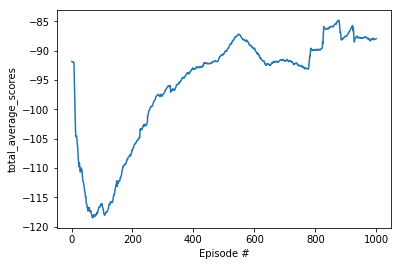

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [36]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-bipedal.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-bipedal.pth', map_location='cpu'))

# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# S = env_info.vector_observations                  # get the current states (S) (for each agent)
s = env.reset() # s: state # get the current state (s) (for an agent)
s_ = np.zeros_like(s)# s_: predicted state # predict the current state (s) (by the agent)
# print(s.shape)

#Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for each agent)
R = 0 # R:total reward # initialize the total score (R) (for an agent)

while True:
    #A = agent.act(S)                        # select actions (A) from loaded model agents
    s = np.reshape(s, [1, -1])
    s_ = np.reshape(s_, [1, -1])
    a = agent.act(s, s_) # a: [-1, +1]    # select action (a) from loaded model agent
    #a = agent.act(s)
    #print(s.shape, a.shape)
    
    # env_info = env.step(A)[brain_name]           # send all actions (A) to tne environment (env)
    # S2 = env_info.vector_observations         # get next states (S2) (for each agent)
    # rewards = env_info.rewards                         # get rewards (for each agent)
    # dones = env_info.local_done                        # see if the episode is done/finished (terminal)
    s2, r, done, _ = env.step(np.reshape(a, [-1]))
    #s2, r, done = env.step(a)
    
    #s2_, q_ = agent.env(s, a)
    s2_, _ = agent.env(s, a)
    
    # Rs += env_info.rewards                         # update the total scores (Rs) (for each agent)
    # S = S2                               # roll over current states (S) to next states (S2)
    R += r # update the total score (R) (for an agent)
    s = s2 # roll over current state (s) to next state (s2)
    s_ = s2_ # roll over the predcited current state (s) to the predicted next state (s2_)
    
    #if np.any(dones):                                  # exit loop if episode is done/finished
    if done: # exit loop if episode is done/finished (terminal)
        break
        
print('Average of total scores: {}'.format(R))

Average of total scores: -106.75700939138544


When finished, you can close the environment.

In [37]:
env.close()